# Make a coastal sfincs model from scratch using hydromt

This notebook demonstrates how to prepare and inspect a SFINCS model from scratch. The notebook does not contain the SFINCS code or executables to run the model with. 

We will make a schematization with the following features:
* we only simulate coastal flooding, we do not consider any interactions with riverine flooding
* we use the MERIT Hydro dataset as elevation
* we include boundary conditions from the Global Tide and Surge Model by imposing a number of boundary points where forcing is expected

All lines in this notebook which start with `!` are executed from the command line. Within jupyter (except for jupyter lab) the logging messages are shown after completion. You can also copy these lines and paste these in your shell to get more direct feedback.

### HydroMT CLI build interface


First let us see what hydromt provides us with.

In [1]:
!hydromt --help

Usage: hydromt [OPTIONS] COMMAND [ARGS]...

  Command line interface for hydromt models.

Options:
  --version  Show the version and exit.
  --models   Print availabe model plugins and exit.
  --help     Show this message and exit.

Commands:
  build   Build models
  clip    Clip models.
  update  Update models


With the `models` flag we can ask if hydroMT recognizes the SFINCS plugin (SFINCS should be mentioned):

In [2]:
!hydromt --models

hydroMT model plugins: sfincs (v0.2.1)


It looks like we have several commands that we can consider. We want to `build` a model. How does that work? We can also call `--help` on the available hydroMT commands as follows.

In [3]:
!hydromt build --help

Usage: hydromt build [OPTIONS] MODEL MODEL_ROOT REGION

  Build models from scratch.

  Example usage:
  --------------

  To build a wflow model for a subbasin using and point coordinates snapped to cells with stream order >= 4
  hydromt build wflow /path/to/model_root "{'subbasin': [-7.24, 62.09], 'strord': 4}" -i /path/to/wflow_config.ini -d deltares_data -d /path/to/data_catalog.yml -v

  To build a sfincs model based on a bbox
  hydromt build sfincs /path/to/model_root "{'bbox': [4.6891,52.9750,4.9576,53.1994]}" -i /path/to/sfincs_config.ini -d /path/to/data_catalog.yml -v

Options:
  -r, --res FLOAT             Model resolution in model src.
  --build-base / --build-all  Deprecated!
  --opt TEXT                  Method specific keyword arguments, see the
                              method documentation of the specific model for
                              more information about the arguments.
  -i, --config PATH           Path to hydroMT configuration file, for the
          

### Building a first model (and getting an error when data is missing)
Let's try to build an entire schematization, just from the command line (Awesome!!!). In the `--help` section, there is an example for making a model from a bounding box, which is very intuitive. Let's try exactly that. We store the model on the local path `./texel_sfincs`

In [4]:
!hydromt build sfincs ./texel_sfincs "{'bbox': [4.68,52.97,4.96,53.20]}"

2022-09-26 11:25:54,370 - build - sfincs - ERROR - depfile = sfincs.dep not found
2022-09-26 11:25:54,370 - build - sfincs - ERROR - mskfile = sfincs.msk not found
2022-09-26 11:25:54,370 - build - sfincs - ERROR - indexfile = sfincs.ind not found


The above might have taken a few seconds, but then should have miserably crashed! What happened:
* HydroMT was looking for a data catalog to use. 
* It did not find any and therefore, it automatically downloaded a sample data catalog which you can now find on your home folder under .hydromt_data
* It tried to build a model in the Texel bounding box, but...alas, the sample dataset does not cover Texel at all! To add datasets covering the area outside the sample data extent, setup your own datasets using data yml files [hydroMT data](https://deltares.github.io/hydromt/latest/user_guide/data.html) using `--data PATH` option, or if your are connected to the Deltares network `--deltares-data` flag.


### Building a first model (and getting it right)
Let's adapt the bounding box to an area that fits within the sample dataset. The dataset covers the Piave basin and its surroundings in Italy. A good place to get a CSV formatted bounding box is https://boundingbox.klokantech.com/

We also add `-vv` for extra verbosity

In [5]:
!hydromt build sfincs ./venice_sfincs "{'bbox': [12.05,45.30,12.85,45.65]}" -vv

2022-09-26 11:26:05,077 - build - log - DEBUG - Writing log messages to new file C:\Users\morenodu\OneDrive - Stichting Deltares\Documents\GitHub\hydromt_sfincs\examples\venice_sfincs\hydromt.log.
2022-09-26 11:26:05,077 - build - log - INFO - HydroMT version: 0.5.0
2022-09-26 11:26:05,078 - build - main - INFO - Building instance of sfincs model at C:\Users\morenodu\OneDrive - Stichting Deltares\Documents\GitHub\hydromt_sfincs\examples\venice_sfincs.
2022-09-26 11:26:05,078 - build - main - INFO - User settings:
2022-09-26 11:26:05,084 - build - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1)
2022-09-26 11:26:05,085 - build - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1).
2022-09-26 11:26:05,085 - build - model_api - INFO - setup_region.region: {'bbox': [12.05, 45.3, 12.85, 45.65]}
2022-09-26 11:26:05,085 - build - model_api - INFO - setup_region.hydrography_fn: merit_hydro
2022-09-26 11:26:05,085 - build - m

This should work without any errors. 

The example above means the following: run **hydromt build** with:

* `sfincs` : i.e. build a SFINCS model
* `./venice_sfincs` : output model folder
* `"{'bbox': [12.05,45.30,12.85,45.65]}"` : make a model that is active for the full given bounding box. All *REGION* options are described in the [docs](https://deltares.github.io/hydromt/latest/user_guide/cli.html#region-options)
* `-vv` : give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

NOTE: As we did not specify a model configuration, only the model region has been setup. To build a complete model we need the use a configuration ini-file.

When we inspect the newly created `./venice_sfincs` folder we only find a log file and the gis folder containing the region geometry saved as geojson file.

In [15]:
!dir venice_sfincs

 Volume in drive C is System
 Volume Serial Number is 3833-993E

 Directory of c:\Users\morenodu\OneDrive - Stichting Deltares\Documents\GitHub\hydromt_sfincs\examples\venice_sfincs

26-09-2022  11:26    <DIR>          .
26-09-2022  11:26    <DIR>          ..
26-09-2022  11:26    <DIR>          gis
26-09-2022  11:26             2.444 hydromt.log
26-09-2022  11:26            24.371 hydromt_data.yml
26-09-2022  11:26               683 sfincs.inp
               3 File(s)         27.498 bytes
               3 Dir(s)  35.355.185.152 bytes free


### Building a complete model (ready to run)

We can provide many more settings in an configuration (.ini) file instead of command line arguments. If you don't provide an ini file (as done above), only the model region is determined. To complete your model you can add more [model components](https://deltares.github.io/hydromt_sfincs/latest/user_guide/sfincs.html) to the model setup.

Let's have a look a typical ini file for setting up coastal SFINCS model, where each `[setup_<>]` refers to a model component. All options which end with `_fn` refers to a data source from the data catalog or a path to data on your machine, see [hydroMT data](https://deltares.github.io/hydromt/latest/user_guide/data.html). In this case some sample data which is downloaded to your machine at `$USER_ROOT/.hydromt_data`

In [11]:
fn_ini = "sfincs_coastal.ini"
with open(fn_ini, "r") as f:
    txt = f.read()
print(txt)

[setup_config]
tref = 20100201 000000
tstart = 20100201 000000
tstop = 20100210 000000
alpha = 0.5
zsini = 0.5

[setup_topobathy]
topobathy_fn = merit_hydro       # topobathy basemaps ['elevtn']
crs = utm                       # model CRS (must be UTM zone)

[setup_merge_topobathy]
topobathy_fn = gebco            # bathymetry ['elevtn']
mask_fn = osm_coastlines        # sea polygon describing where we want to use the new data
offset_fn = dtu10mdt_egm96      # mean dynamic topography to account for the difference in vertical datum between the current and new data
merge_method = first            # use valid new data where the current data has invalid (nodata) values
merge_buffer = 2                # buffer (cells) between elevation and bathymetry data filled with 'linear' interpolation

[setup_mask]
elv_min = -5                    # minimum elevation for valid cells

[setup_cn_infiltration]
cn_fn = gcn250                  # curve number source
antecedent_runoff_conditions = avg # for gcn

You can see the following sections:

* `[setup_config]`: arguments which are forwarded to the SFINCS model configuration file sfincs.inp
* `[setup_topobathy]`: basic information required for the model domain grid and elevation. These are the minimal demanded static layers that any SFINCS model needs. Here you may for instance consider altering the elevation and bathymetry data for local data sources. These then have to be supplied in the `data_catalog.yml`.
* `[setup_merge_topobathy]`: add additional data source for bathymetry data to merge with the basemap elevation data.
* `[setup_mask]`: set valid model cells based on the topobathy data and a minimal depth boundary (more options available).
* `[setup_cn_infiltration]`: potential maximum soil retention maps to be used in the curve number method, see [SFINCS docs](https://sfincs.readthedocs.io/en/latest/input.html?highlight=curve#spatially-varying-curve-number) for more information
* `[setup_manning_roughness]`: configuration of the Manning roughness values, typically consisting of a land use or land cover map, and a lookup table that relates land use classes to manning roughness values in sec m$^{-1/3}$
* `[setup_bounds]`: set cells at the model domain edge and within the sea polygon to waterlevel boundary cells.
* `[setup_h_forcing]`: water level forcing data. This can be provided from a set of csv files, see data_sources.yml, but also netcdf files, see [hydroMT docs](https://deltares.github.io/hydromt/latest/user_guide/data.html). 
* `[setup_p_forcing_from_grid]`: gridded precipitation data, that can be used to do compound flood simulations. The `[setup_cn_infiltration]` is then quite essential to include.

To build a model from scratch add the ini file to the command line `hydromt build` method at a 150 m resolution.

In [8]:
!hydromt build sfincs ./venice_sfincs_150 "{'bbox': [12.05,45.30,12.85,45.65]}" -r 150 -i sfincs_coastal.ini -vv

2022-09-26 11:28:48,676 - build - log - DEBUG - Writing log messages to new file C:\Users\morenodu\OneDrive - Stichting Deltares\Documents\GitHub\hydromt_sfincs\examples\venice_sfincs_150\hydromt.log.
2022-09-26 11:28:48,676 - build - log - INFO - HydroMT version: 0.5.0
2022-09-26 11:28:48,676 - build - main - INFO - Building instance of sfincs model at C:\Users\morenodu\OneDrive - Stichting Deltares\Documents\GitHub\hydromt_sfincs\examples\venice_sfincs_150.
2022-09-26 11:28:48,676 - build - main - INFO - User settings:
2022-09-26 11:28:48,686 - build - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1)
2022-09-26 11:28:48,687 - build - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1).
2022-09-26 11:28:48,687 - build - model_api - INFO - setup_region.region: {'bbox': [12.05, 45.3, 12.85, 45.65]}
2022-09-26 11:28:48,687 - build - model_api - INFO - setup_region.hydrography_fn: merit_hydro
2022-09-26 11:28:48,687 - b

Let's inspect the output folder. Notice that several SFINCS files have been written.

In [13]:
!dir venice_sfincs_150

 Volume in drive C is System
 Volume Serial Number is 3833-993E

 Directory of c:\Users\morenodu\OneDrive - Stichting Deltares\Documents\GitHub\hydromt_sfincs\examples\venice_sfincs_150

26-09-2022  11:28    <DIR>          .
26-09-2022  11:28    <DIR>          ..
26-09-2022  11:28    <DIR>          gis
26-09-2022  11:28            11.597 hydromt.log
26-09-2022  11:28             3.499 hydromt_data.yml
26-09-2022  11:28               132 sfincs.bnd
26-09-2022  11:28            12.586 sfincs.bzs
26-09-2022  11:28           317.380 sfincs.dep
26-09-2022  11:28           317.384 sfincs.ind
26-09-2022  11:28               772 sfincs.inp
26-09-2022  11:28           317.380 sfincs.man
26-09-2022  11:28            79.345 sfincs.msk
26-09-2022  11:28             3.906 sfincs.precip
26-09-2022  11:28           317.380 sfincs.scs
              11 File(s)      1.381.361 bytes
               3 Dir(s)  35.356.831.744 bytes free


One of the files is the SFINCS input file which defines the model, lets have a look:

In [16]:
fn_inp = "./venice_sfincs_150/sfincs.inp"
with open(fn_inp, "r") as f:
    txt = f.read()

print(txt)

mmax            = 425
nmax            = 272
dx              = 150.0
dy              = 150.0
x0              = 268650.0
y0              = 5018550.0
rotation        = 0
epsg            = 32633
inputformat     = bin
outputformat    = net
tref            = 20100201 000000
tstart          = 20100201 000000
tstop           = 20100210 000000
dtout           = 3600
dthisout        = 600
dtmaxout        = 86400
advection       = 0
alpha           = 0.5
huthresh        = 0.05
theta           = 0.9
min_lev_hmax    = -1
zsini           = 0.5
depfile         = sfincs.dep
mskfile         = sfincs.msk
indexfile       = sfincs.ind
scsfile         = sfincs.scs
manningfile     = sfincs.man
precipfile      = sfincs.precip
bzsfile         = sfincs.bzs
bndfile         = sfincs.bnd




### Inspecting the model
Let's have a closer look at the model. To interact with a model within a notebook or python script, we need to load a number of modules.

In [17]:
%matplotlib inline
from hydromt_sfincs import SfincsModel

Now we can load the model in memory and inspect it. 

Note that based on the global datasets the lagoon bathymetry is not well represented. A better merge between MERIT hydro topography and GEBCO bathymetry can be achieved by providing an better coastline shapefile (by default OSM based) which together with the merge_method argument determines which dataset is used where.

(<Figure size 1300x700 with 2 Axes>,
 <GeoAxesSubplot: title={'center': 'SFINCS dep map'}, xlabel='x coordinate UTM zone 33N [m]', ylabel='y coordinate UTM zone 33N [m]'>)

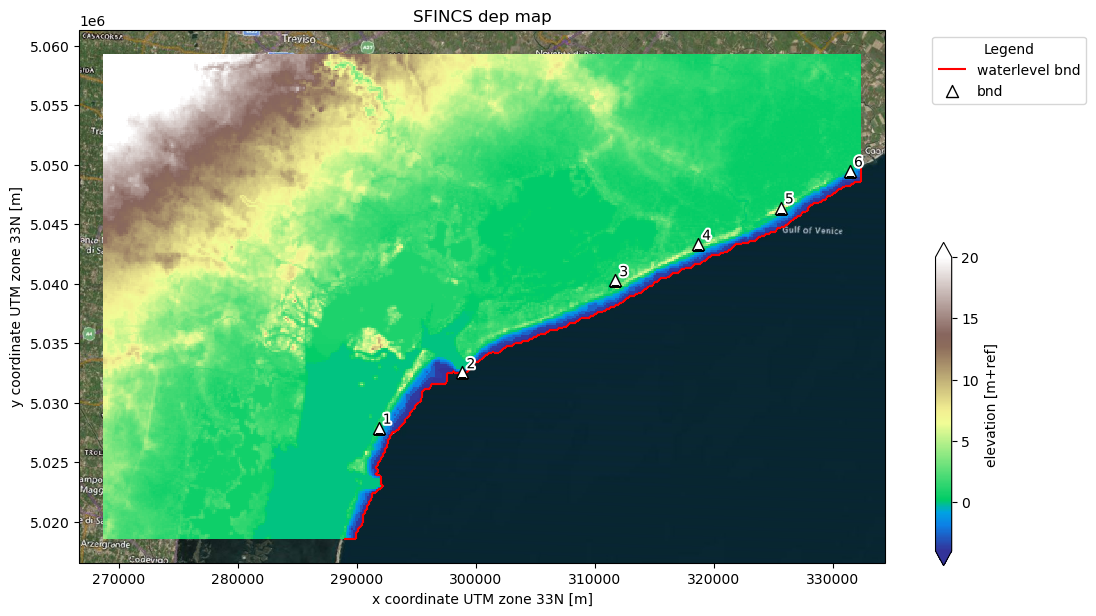

In [18]:
# define the model's configuration file
root = r"./venice_sfincs_150"

# read the model with hydromt methods
mod = SfincsModel(root=root, mode="r")
mod.read()
mod.plot_basemap(figsize=(13, 7), shaded=False)

### Next steps
You can update an existing model, e.g. to replace model layers or add forcing. this is described in a follow-up notebook `sfincs_update_model.ipynb`